<a href="https://colab.research.google.com/github/wjoonkim/tutorials/blob/main/behi5003_fall2025/aav_illumina_seq_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BEHI 5003 Fall 2025
## Tutorial: DNA sequencing data processing and analysis
### Author: Won Joon Kim
### Affiliation: Biomolecular Engineering Lab (BEL), CBE, HKUST

I acknowledge the use of generative AI (Gemini Agent in Colab) in writing the code below.

Only the raw input data and outline was adapted from
the Jupyter notebook authored by Mr. Mingyi Sun (BEL, CBE, HKUST)
during the Fall 2024 offering of BIEN 6930B (this course).

I sincerely thank the authors and maintainers of the packages used in this tutorial!

# 1. Setup the Colab environment for data processing and analysis

In [3]:
# Install conda for command-line tools
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [3]:
# install biopython for sequence analysis on python
try:
    import google.colab
    # Running on Google Colab, so install Biopython first
    !pip install biopython
except ImportError:
    pass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 142.6 MB/s eta 0:00:00


In [1]:
import os
import sys

from urllib.request import urlretrieve

import Bio

print("Python version:", sys.version_info)
print("Biopython version:", Bio.__version__)

Python version: sys.version_info(major=3, minor=12, micro=11, releaselevel='final', serial=0)
Biopython version: 1.85


In [ ]:
# Install the cutadapt package from bioconda
!conda install -c bioconda cutadapt -y

In [ ]:
# read basic info about the cutadapt package
!cutadapt

# 2. Explore how the raw Illumina_demo_pre.fastq file looks like

This is exactly how a FASTQ file looks like:

In [27]:
!head -n 8 /content/Illumina_demo_pre.fastq

@A00887:88:HGJVTDRXX:1:2101:2645:1000 1:N:0:NTGATCGT+TGGTGAAG
GNCTAATGGCCACCAACAACCAGAGAACAGGTAATTATTCTTGGAATTATAAGGGCTTAAGTTCCACCACTGCCCCCGCGACCGGCCGTACAACCTCCTAA
+
F#FFFFFFFFFFFFFF:FFFFFFF,FFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFF
@A00887:88:HGJVTDRXX:1:2101:4074:1000 1:N:0:NTGATCGT+TGGTGAAG
ANGAAATGGCCACCAACAACCAGAGCACAGCTATTGTGCAGCATTCTGATTAGGGCTTAAGTTCCACCACTGCCCCCGCGACCGGCACGTACAACCTCTCT
+
F#FF:FFFFFFFFFFFFFFFFFFF,,,F:,:FFFFFFFFFF:FFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


How many reads are there?

In [37]:
!grep -c '^@' Illumina_demo_pre.fastq

1000


Let's import it to Python to see the base call quality in numbers!

In [16]:
from Bio import SeqIO

fastq_file = 'Illumina_demo_pre.fastq'

try:
    # Open the fastq file and read the first record
    with open(fastq_file, "r") as handle:
        first_read = next(SeqIO.parse(handle, "fastq"))
        # Illumina_demo_pre_seqrecordlist = list(SeqIO.parse(handle, "fastq"))

    # Print the first read
    print(first_read.id)
    print(first_read.seq)
    print(first_read.letter_annotations["phred_quality"])

except FileNotFoundError:
    print(f"Error: The file {fastq_file} was not found.")
except StopIteration:
    print(f"Error: The file {fastq_file} is empty or does not contain valid fastq records.")
except Exception as e:
    print(f"An error occurred: {e}")

A00887:88:HGJVTDRXX:1:2101:2645:1000
GNCTAATGGCCACCAACAACCAGAGAACAGGTAATTATTCTTGGAATTATAAGGGCTTAAGTTCCACCACTGCCCCCGCGACCGGCCGTACAACCTCCTAA
[37, 2, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 25, 37, 37, 37, 37, 37, 37, 37, 11, 37, 37, 37, 11, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 25, 37, 37, 37, 37, 37, 37, 37, 37]


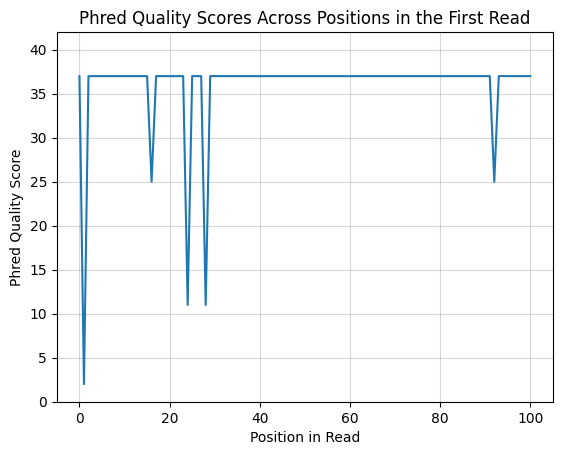

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# line plot of phred qualities in the first read
# Assuming 'first_read' object exists from a previous cell
if 'first_read' in locals():
    phred_qualities = first_read.letter_annotations["phred_quality"]

    sns.lineplot(x=range(len(phred_qualities)), y=phred_qualities)
    plt.title("Phred Quality Scores Across Positions in the First Read")
    plt.xlabel("Position in Read")
    plt.ylabel("Phred Quality Score")
    plt.ylim(0, 42) # Phred scores typically range from 0 to 41
    plt.grid(True, alpha=0.5)
    plt.show()
else:
    print("Error: 'first_read' object not found. Please run the cell to import the first read first.")

How long is the first raw read?

In [14]:
from Bio.Seq import Seq
len(first_read.seq)

101

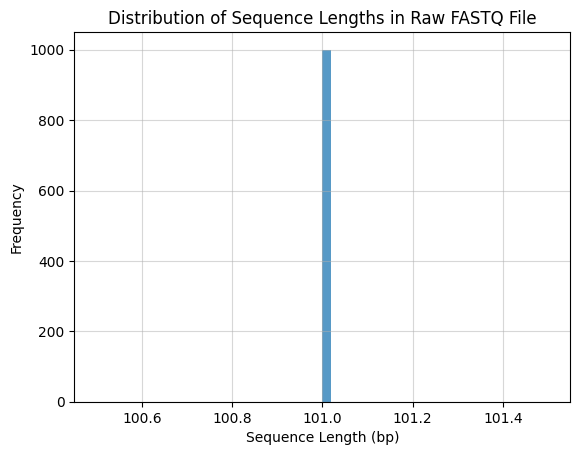

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

fastq_file = 'Illumina_demo_pre.fastq'
sequence_lengths = []

try:
    # Read all sequence lengths from the fastq file
    with open(fastq_file, "r") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            sequence_lengths.append(len(record.seq))

    # Plot a histogram of the sequence lengths
    sns.histplot(sequence_lengths, bins=50, kde=False, edgecolor=None)
    plt.title('Distribution of Sequence Lengths in Raw FASTQ File')
    plt.xlabel('Sequence Length (bp)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.5)
    plt.show()

except FileNotFoundError:
    print(f"Error: The file {fastq_file} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

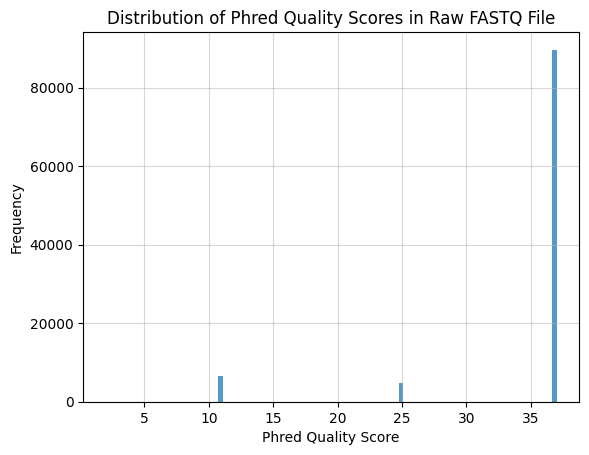

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

all_quals = []

try:
    # Read all quality scores from the fastq file
    with open(fastq_file, "r") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            all_quals.extend(record.letter_annotations['phred_quality'])

    # Plot a histogram of the quality scores
    sns.histplot(all_quals, bins=100, kde=False, edgecolor=None)
    plt.title("Distribution of Phred Quality Scores in Raw FASTQ File")
    plt.xlabel("Phred Quality Score")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.5)
    plt.show()

except FileNotFoundError:
    print(f"Error: The file {fastq_file} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# 3. Remove "adapter" sequences from the data
"adapter" in this case denotes constant sequences flanking the desired 7-mer insertion library

In [5]:
import os

num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

Number of CPU cores available: 2


In [34]:
import subprocess

# set up file paths
raw_input_file = "Illumina_demo_pre.fastq"
untrimmed_output_file = "Illumina_demo_pre_untrimmed.fastq" # discard
lt21_output_file = "Illumina_demo_pre_lt21.fastq" # discard
gt21_output_file = "Illumina_demo_pre_gt21.fastq" # discard
len21_output_file = "Illumina_demo_pre_len21.fastq" # keep

# define adapter sequences
fiveprime_adapter_seq = "ccaacaaccagagcaccggt"
threeprime_adapter_seq = "ggcttaagttccaccactgc"

# desired length of library sequence
library_len = 21

# Define the cutadapt command and arguments
command = [
    "cutadapt",
    "--cores", f"{num_cores}", # Using all available cores in the environment
    "--adapter", f"{fiveprime_adapter_seq}...{threeprime_adapter_seq}",
    "--untrimmed-output", untrimmed_output_file,
    "--minimum-length", f"{library_len}",
    "--too-short-output", lt21_output_file,
    "--maximum-length", f"{library_len}",
    "--too-long-output", gt21_output_file,
    "--output", len21_output_file,
    raw_input_file,
]

# Execute the command
try:
    subprocess.run(command, check=True)
    print("Cutadapt command executed successfully.")
except subprocess.CalledProcessError as e:
    print(f"Error executing cutadapt command: {e}")
except FileNotFoundError:
    print("Error: cutadapt command not found. Make sure cutadapt is installed and in your PATH.")

Cutadapt command executed successfully.


# 4. Check the desired output file

In [38]:
!head -n 8 Illumina_demo_pre_len21.fastq

@A00887:88:HGJVTDRXX:1:2101:2645:1000 1:N:0:NTGATCGT+TGGTGAAG
AATTATTCTTGGAATTATAAG
+
FFFFFFFFFFFFFFFFFFFFF
@A00887:88:HGJVTDRXX:1:2101:4074:1000 1:N:0:NTGATCGT+TGGTGAAG
ATTGTGCAGCATTCTGATTAG
+
FFFFFFFFF:FFFFFFFF:FF


How many reads are left after keeping only the desired lengths?

In [36]:
!grep -c '^@' Illumina_demo_pre_len21.fastq

343


# 5. Convert into amino acid residues

In [41]:
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd
import argparse
from tqdm import tqdm

def count_unique_dna_seq(fastq_file):
    """
    Reads DNA sequences from a fastq file, counts the occurrences of each unique sequence,
    and stores the results in a pandas DataFrame.

    Parameters:
    fastq_file (str): Path to the input fastq file.

    Returns:
    pd.DataFrame: DataFrame containing unique sequences and their counts.
    """
    sequence_counts = {}

    # Read sequences from the fastq file with tqdm progress bar
    for record in tqdm(SeqIO.parse(fastq_file, "fastq"), desc="Parsed: ", unit=" sequences", dynamic_ncols=True):
        sequence = str(record.seq)
        if sequence in sequence_counts:
            sequence_counts[sequence] += 1
        else:
            sequence_counts[sequence] = 1

    # Convert the dictionary to a pandas DataFrame
    df = pd.DataFrame(list(sequence_counts.items()), columns=['sequence', 'count'])
    df['length'] = df['sequence'].apply(len)
    df['amino_acid'] = df['sequence'].apply(lambda seq: str(Seq(seq).translate()))

    return df

def count_unique_aa_seq(df):
    """
    Counts the occurrences of each unique amino acid sequence in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing DNA sequences, their counts, lengths, and translations.

    Returns:
    pd.DataFrame: DataFrame containing unique amino acid sequences, their summed counts, and occurrences.
    """
    # Group by amino_acid and aggregate the sum of counts and the occurrence
    amino_acid_counts_df = df.groupby('amino_acid').agg(
        count=('count', 'sum'),
        occurrence=('amino_acid', 'count')
    ).reset_index()

    return amino_acid_counts_df

def filter_codons(df):
    """
    Filters out sequences with a '*' (stop codon) or 'X' (unconfident base call) in the amino_acid column.

    Parameters:
    df (pd.DataFrame): DataFrame containing unique amino acid sequences, their summed counts, and occurrences.

    Returns:
    tuple: A tuple containing two DataFrames:
        - Filtered DataFrame without sequences containing "*" or "X".
        - DataFrame containing sequences that were filtered out.
    """
    filtered_df = df[~df['amino_acid'].str.contains(r'\*|X')]
    filtered_out_df = df[df['amino_acid'].str.contains(r'\*|X')]

    return filtered_df, filtered_out_df

In [44]:
input_file = "Illumina_demo_pre_len21.fastq"
dna_df = count_unique_dna_seq(input_file)
dna_output_file = "Illumina_demo_pre_len21_dna.csv"
dna_df.to_csv(dna_output_file, index=False)
print(f"\n{len(dna_df)} DNA variants saved.")

amino_acid_df = count_unique_aa_seq(dna_df)
amino_acid_output_file = "Illumina_demo_pre_len21_aa.csv"
amino_acid_df.to_csv(amino_acid_output_file, index=False)
print(f"{len(amino_acid_df)} raw amino acid variants saved.")

filtered_amino_acid_df, filtered_out_amino_acid_df = filter_codons(amino_acid_df)
filtered_amino_acid_output_file = "Illumina_demo_pre_len21_aa_filtered.csv"
filtered_amino_acid_df.to_csv(filtered_amino_acid_output_file, index=False)
print(f"{len(filtered_amino_acid_df)} filtered amino acid variants saved.")

filtered_out_amino_acid_output_file = "Illumina_demo_pre_len21_aa_filtered_out.csv"
filtered_out_amino_acid_df.to_csv(filtered_out_amino_acid_output_file, index=False)
print(f"{len(filtered_out_amino_acid_df)} filtered out amino acid variants saved.")

Parsed: : 343 sequences [00:00, 96198.35 sequences/s]


342 DNA variants saved.
342 raw amino acid variants saved.
278 filtered amino acid variants saved.
64 filtered out amino acid variants saved.


# 6. Visualizing the 7-mer insertion variants we have in our data

In [47]:
display(filtered_amino_acid_df)

,amino_acid,count,occurrence
16,AANFSFL,1,1
17,AGRFLCF,1,1
18,ALDCIVL,1,1
19,AMFFLLF,1,1
20,AMSFSTC,1,1
...,...,...,...
335,YRGYPLI,1,1
336,YRILLDF,1,1
338,YSFIHSD,1,1
339,YVFQLMD,1,1


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate the frequencies of each character at each position in the sequences
def calculate_frequencies(df):
    frequencies = {}
    for index, row in df.iterrows():
        value = row['amino_acid']
        count = row['count']
        for i, char in enumerate(value):
            freq_dict = frequencies.get(i + 1, {})
            freq_dict[char] = freq_dict.get(char, 0) + count
            frequencies[i + 1] = freq_dict
    return frequencies

In [55]:
# Calculate the frequencies of each character at each position
freq = calculate_frequencies(filtered_amino_acid_df)

# Convert the frequencies dictionary to a DataFrame
freq_df = pd.DataFrame(freq)

display(freq_df)

,1,2,3,4,5,6,7
A,8,7,10,9,7.0,6.0,6
C,3,12,15,17,10.0,16.0,10
D,11,13,8,9,11.0,4.0,9
E,5,6,7,1,NaN,3.0,2
F,33,21,31,34,35.0,64.0,51
G,9,4,8,7,9.0,2.0,1
H,16,5,13,14,20.0,5.0,7
I,17,30,20,26,17.0,31.0,29
K,4,9,2,1,2.0,4.0,4
L,46,29,24,18,50.0,41.0,33


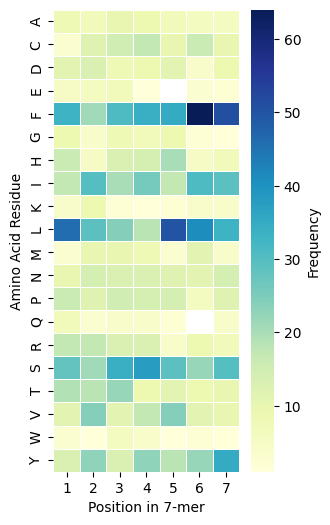

In [56]:
# Plot a heatmap of the frequencies
plt.figure(figsize=(3, 6))
sns.heatmap(freq_df,
            cmap='YlGnBu',
            xticklabels=range(1, freq_df.shape[1] + 1),
            linewidths=0.5,
            cbar_kws={'label': 'Frequency'}) # add "Frequency" as colormap title
plt.xlabel('Position in 7-mer')
plt.ylabel('Amino Acid Residue')
plt.show()